# Non-Fungible Tokens: Empirical Asset Pricing with Machine Learning

In [43]:
#from google.colab import drive
#drive.mount('/content/drive')

## Setup

In [44]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
from sklearn import preprocessing
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error,r2_score
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

## Data Extraction

In [45]:
# Excel
df_trends = pd.read_excel('data/google_trends.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_tokens = pd.read_excel('data/df_tokens.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_collection = pd.read_excel('data/nonfungible-art-blocks.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_market = pd.read_excel('data/nonfungible-market.xlsx', usecols=lambda x: 'Unnamed' not in x) 

# CSV
df_provenance = pd.read_csv('data/df_provenance.csv', usecols=lambda x: 'Unnamed' not in x) 
df_traits = pd.read_csv('data/df_traits.csv', usecols=lambda x: 'Unnamed' not in x) 
df_txn = pd.read_csv('data/df_txn.csv', usecols=lambda x: 'Unnamed' not in x) 
df_eth = pd.read_csv('data/ETH-USD.csv', usecols=lambda x: 'Unnamed' not in x) 
df_tokens_minted = pd.read_csv('data/tokens_minted.csv', usecols=lambda x: 'Unnamed' not in x)

df_makert_cap = pd.read_excel('data/market_cap.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_floor_price = pd.read_excel('data/floor_price.xlsx', usecols=lambda x: 'Unnamed' not in x) 

In [46]:
'''# Excel
df_trends = pd.read_excel('/content/drive/MyDrive/Tese/data/google_trends.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_tokens = pd.read_excel('/content/drive/MyDrive/Tese/data/df_tokens.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_collection = pd.read_excel('/content/drive/MyDrive/Tese/data/nonfungible-art-blocks.xlsx', usecols=lambda x: 'Unnamed' not in x) 
df_market = pd.read_excel('/content/drive/MyDrive/Tese/data/nonfungible-market.xlsx', usecols=lambda x: 'Unnamed' not in x) 

# CSV
df_provenance = pd.read_csv('/content/drive/MyDrive/Tese/data/df_provenance.csv', usecols=lambda x: 'Unnamed' not in x) 
df_traits = pd.read_csv('/content/drive/MyDrive/Tese/data/df_traits.csv', usecols=lambda x: 'Unnamed' not in x) 
df_txn = pd.read_csv('/content/drive/MyDrive/Tese/data/df_txn.csv', usecols=lambda x: 'Unnamed' not in x) 
df_eth = pd.read_csv('/content/drive/MyDrive/Tese/data/ETH-USD.csv', usecols=lambda x: 'Unnamed' not in x) 
df_tokens_minted = pd.read_csv('/content/drive/MyDrive/Tese/data/tokens_minted.csv', usecols=lambda x: 'Unnamed' not in x)'''

"# Excel\ndf_trends = pd.read_excel('/content/drive/MyDrive/Tese/data/google_trends.xlsx', usecols=lambda x: 'Unnamed' not in x) \ndf_tokens = pd.read_excel('/content/drive/MyDrive/Tese/data/df_tokens.xlsx', usecols=lambda x: 'Unnamed' not in x) \ndf_collection = pd.read_excel('/content/drive/MyDrive/Tese/data/nonfungible-art-blocks.xlsx', usecols=lambda x: 'Unnamed' not in x) \ndf_market = pd.read_excel('/content/drive/MyDrive/Tese/data/nonfungible-market.xlsx', usecols=lambda x: 'Unnamed' not in x) \n\n# CSV\ndf_provenance = pd.read_csv('/content/drive/MyDrive/Tese/data/df_provenance.csv', usecols=lambda x: 'Unnamed' not in x) \ndf_traits = pd.read_csv('/content/drive/MyDrive/Tese/data/df_traits.csv', usecols=lambda x: 'Unnamed' not in x) \ndf_txn = pd.read_csv('/content/drive/MyDrive/Tese/data/df_txn.csv', usecols=lambda x: 'Unnamed' not in x) \ndf_eth = pd.read_csv('/content/drive/MyDrive/Tese/data/ETH-USD.csv', usecols=lambda x: 'Unnamed' not in x) \ndf_tokens_minted = pd.read_csv

## Data Preparation

In [47]:
# Get transactions
df_transactions = df_provenance.merge(df_txn, how='inner', left_on=['txHash'], right_on=['hash'], suffixes=('', ''),indicator=False)
df_transactions.rename(columns={"value": "price","date":"DATETIME"},inplace=True)

# Drop duplicates
df_transactions.drop_duplicates(inplace=True)

# Get eth price and volume traded
df_transactions['DATETIME'] = pd.to_datetime(df_transactions['DATETIME'], infer_datetime_format=True)
df_transactions['DATE'] = df_transactions['DATETIME'].dt.date
df_transactions['DATE'] = pd.to_datetime(df_transactions['DATE'], infer_datetime_format=True)

df_eth.rename(columns={"Close": "ETH_CLOSE_PRICE", "Volume": "ETH_TRADED_VOLUME"},inplace=True)
df_eth['Date'] = pd.to_datetime(df_eth['Date'])

df_transactions = df_transactions.merge(df_eth[['Date','ETH_CLOSE_PRICE','ETH_TRADED_VOLUME']], how='left', left_on=['DATE'], right_on=['Date'], suffixes=('', ''),indicator=False)
df_transactions.drop(columns=['Date'],inplace=True)


# Get interest score
df_trends['DATE'] = pd.to_datetime(df_trends['DATE'])
df_transactions = df_transactions.merge(df_trends[['DATE','INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS']], how='left', left_on=['DATE'], right_on=['DATE'], suffixes=('', ''),indicator=False)


# Get market data
df_market['DateTime'] = pd.to_datetime(df_market['DateTime'])
df_transactions = df_transactions.merge(df_market[['DateTime', 'Number of sales', 'Sales USD', 'Active market wallets',
       'Unique buyers', 'Unique sellers']], how='left', left_on=['DATE'], right_on=['DateTime'], suffixes=('', ''),indicator=False)
df_transactions.drop(columns=['DateTime'],inplace=True)


# Get collection active market wallets
df_collection['DateTime'] = pd.to_datetime(df_collection['DateTime'])
df_transactions = df_transactions.merge(df_collection[['DateTime', 'Active market wallets','Unique buyers', 'Unique sellers']], how='left', left_on=['DATE'], right_on=['DateTime'], suffixes=('', ' collection'),indicator=False)
df_transactions.drop(columns=['DateTime'],inplace=True)


# Get tokens minted
df_tokens_minted['evt_block_time'] = pd.to_datetime(df_tokens_minted['evt_block_time'])
tokens_minted_dt = pd.date_range(df_tokens_minted.evt_block_time.min(),df_tokens_minted.evt_block_time.max()-timedelta(days=1),freq='d')
tokens_minted_df_dt = pd.DataFrame(tokens_minted_dt,columns=['dt'])
df_tokens_minted = tokens_minted_df_dt.merge(df_tokens_minted, how='left', left_on=['dt'], right_on=['evt_block_time'], suffixes=('', ''),indicator=False)
df_tokens_minted.sort_values(by='dt', ascending=True,inplace=True)
df_tokens_minted.fillna(0,inplace=True)
df_tokens_minted['tokens_available'] = df_tokens_minted.tokens_minted.cumsum()
df_transactions = df_transactions.merge(df_tokens_minted, how='left', left_on=['DATE'], right_on=['dt'], suffixes=('', ''),indicator=False)
df_transactions.drop(columns=['evt_block_time','dt'],inplace=True)


# Add Action category
df_transactions.loc[df_transactions['from'] == '0x0000000000000000000000000000000000000000','Action'] = 'Mint'
df_transactions.loc[(df_transactions['price'] == 0)&(df_transactions['from'] != '0x0000000000000000000000000000000000000000'),'Action'] = 'Transfer'
df_transactions.loc[(df_transactions['price'] > 0)&(df_transactions['from'] != '0x0000000000000000000000000000000000000000'),'Action'] = 'Sale'


# Add bundle transactions flag
df_bundles = df_transactions.groupby('hash', as_index=False)[['collectionTokenId','price']].nunique()
df_bundles = df_bundles[(df_bundles['collectionTokenId']>1)&(df_bundles['price'])==1]
df_bundles['is_bundle'] = 1
df_bundles['nb_tokens_bundle'] = df_bundles['collectionTokenId']

df_transactions = df_transactions.merge(df_bundles[['hash','is_bundle','nb_tokens_bundle']], how='left', left_on=['hash'], right_on=['hash'], suffixes=('', ''),indicator=False)
df_transactions['is_bundle'] = df_transactions['is_bundle'].fillna(0)

df_transactions.loc[(df_transactions['is_bundle'] == 1)&(df_transactions['Action'] == 'Sale'),'price'] = df_transactions['price']/df_transactions['nb_tokens_bundle']
df_transactions.drop(columns=['nb_tokens_bundle'],inplace=True)


# Add collection volume and sales
df_sales = df_transactions[df_transactions['Action'] == 'Sale']
df_sales_ = df_sales.groupby('DATE', as_index=False)[['DATE','price','hash']].agg({"price": np.sum,"hash": lambda x: x.nunique()})

df_sales_['Transactions collection ETH'] = df_sales_['price']
df_sales_['Number of Transactions collection'] = df_sales_['hash']
df_sales_['Action'] = 'Sale'

df_transactions = df_transactions.merge(df_sales_[['DATE','Transactions collection ETH','Number of Transactions collection','Action']], how='left', left_on=['DATE','Action'], right_on=['DATE','Action'], suffixes=('', ''),indicator=False)
df_transactions['Transactions collection USD'] = df_transactions['ETH_CLOSE_PRICE']*df_transactions['Transactions collection ETH']


In [48]:
### TRAITS ###
df_traits.fillna('None',inplace=True)
df_traits_tt = df_traits.groupby('collectionTokenId', as_index=False)[['trait_type','value']].agg({"trait_type": lambda x: x.nunique(),"value": lambda x: x.nunique()})
df_traits_tt.rename(columns={"trait_type": "number_trait_types", "value": "number_trait_values"},inplace=True)


df_traits_t = df_traits.groupby('value', as_index=False)[['collectionTokenId']].nunique()
df_traits_t.rename(columns={"collectionTokenId": "number_tokens_trait_value"},inplace=True)
df_traits_t.sort_values('number_tokens_trait_value', ascending=True, inplace=True)
#df_traits_t['rank_rarity_trait_value'] = df_traits_t['number_tokens_trait_value'].rank(ascending=True,pct=True)
df_traits_t['rarity_trait_value'] = df_traits_t['number_tokens_trait_value']/df_traits_t['number_tokens_trait_value'].sum()
df_traits_t['rarity_trait_value'] = df_traits_t['rarity_trait_value']*100


df_traits_ty = df_traits.groupby('trait_type', as_index=False)[['collectionTokenId']].nunique()
df_traits_ty.rename(columns={"collectionTokenId": "number_tokens_trait_type"},inplace=True)
df_traits_ty.sort_values('number_tokens_trait_type', ascending=True, inplace=True)
#df_traits_ty['rank_rarity_trait_type'] = df_traits_ty['number_tokens_trait_type'].rank(ascending=True,pct=True)
df_traits_ty['rarity_trait_type'] = df_traits_ty['number_tokens_trait_type']/df_traits_ty['number_tokens_trait_type'].sum()
df_traits_ty['rarity_trait_type'] = df_traits_ty['rarity_trait_type']*100


df_traits_ = df_traits.merge(df_traits_t, how='left', left_on=['value'], right_on=['value'], suffixes=('', ''),indicator=False)
df_traits_ = df_traits_.groupby(['collectionTokenId','trait_type'], as_index=False)[['rarity_trait_value']].mean()
df_traits_ = df_traits_.merge(df_traits_tt[['collectionTokenId','number_trait_values']], how='left', on=['collectionTokenId'], suffixes=('', ''),indicator=False)
df_traits_final = df_traits_.merge(df_traits_ty[['trait_type','rarity_trait_type']], how='left', on=['trait_type'], suffixes=('', ''),indicator=False)


In [49]:
# Add market cap and floor price
df_transactions = df_transactions.merge(df_makert_cap, how='left', on=['DATE'], suffixes=('', ''),indicator=False)
df_transactions = df_transactions.merge(df_floor_price, how='left', on=['DATE'], suffixes=('', ''),indicator=False)

df_transactions['floor_price'] = df_transactions['floor_price'].fillna(0)

In [50]:
# Create final transaction set
df_transactions_final = df_transactions.merge(df_traits_final, how='left', on=['collectionTokenId'], suffixes=('', ''),indicator=False)

# Fill missing values
df_transactions_final['rarity_trait_type'] = df_transactions_final['rarity_trait_type'].fillna(df_traits_final[df_traits_final['trait_type'] =='None']['rarity_trait_type'].min())
df_transactions_final['number_trait_values'] = df_transactions_final['number_trait_values'].fillna(0)
df_transactions_final['trait_type'] = df_transactions_final['trait_type'].fillna('None')
df_transactions_final['rarity_trait_value'] = df_transactions_final['rarity_trait_value'].fillna(df_traits_final[df_traits_final['trait_type'] =='None']['rarity_trait_value'].min())

# Filter dataset by date
df_transactions_final = df_transactions_final[df_transactions_final['DATE']<pd.to_datetime('2022-07-01')]
df_transactions_final.reset_index(drop=True,inplace=True)


In [51]:
df_transactions_final.isnull().sum()

blockNumber                               0
DATETIME                                  0
from                                      0
to                                        0
txHash                                    0
collectionTokenId                         0
hash                                      0
price                                     0
gasPrice                                  0
gas                                       0
DATE                                      0
ETH_CLOSE_PRICE                           0
ETH_TRADED_VOLUME                         0
INTEREST_SCORE_NFT                        0
INTEREST_SCORE_ARTBLOCKS                  0
Number of sales                           0
Sales USD                                 0
Active market wallets                     0
Unique buyers                             0
Unique sellers                            0
Active market wallets collection          0
Unique buyers collection                  0
Unique sellers collection       

In [52]:
print(df_transactions_final.DATE.min(),df_transactions_final.DATE.max())

2020-12-12 00:00:00 2022-06-30 00:00:00


In [53]:
# Create final sales dataset
df_sales_final = df_transactions_final[df_transactions_final['Action']=='Sale']
df_sales_final.reset_index(drop=True,inplace=True)
print(df_sales_final.DATE.min(),df_sales_final.DATE.max())
#df_sales_final

## Add NFT metrics to sales dataframe

df_sales_final['transaction_order'] = df_sales_final.sort_values(['DATETIME'], ascending=True) \
             .groupby(['collectionTokenId']) \
             .cumcount() + 1

df_sales_final_rn = df_sales_final[['DATETIME','collectionTokenId','price','transaction_order']]

df_sales_final_rn['transaction_order'] = df_sales_final_rn['transaction_order'] + 1

df_sales_final = df_sales_final.merge(df_sales_final_rn, how='left', on=['collectionTokenId','transaction_order'], 
                                   suffixes=('', '_previous'),indicator=False)

df_mint = df_transactions_final[df_transactions_final['Action']=='Mint'][['DATETIME','collectionTokenId','price']]
df_sales_final = df_sales_final.merge(df_mint, how='left', on=['collectionTokenId'], 
                                   suffixes=('', '_mint'),indicator=False)

df_first = df_sales_final[df_sales_final['transaction_order']==1][['DATETIME','collectionTokenId','price']]
df_sales_final = df_sales_final.merge(df_first, how='left', on=['collectionTokenId'], 
                                   suffixes=('', '_first_txn'),indicator=False)

# Missing values
df_sales_final.loc[df_sales_final.DATETIME_mint.isnull()==True,'DATETIME_mint'] = df_sales_final['DATETIME_first_txn']
df_sales_final.loc[df_sales_final.price_mint.isnull()==True,'price_mint'] = df_sales_final['price_first_txn']

df_sales_final.loc[df_sales_final.DATETIME_previous.isnull()==True,'DATETIME_previous'] = df_sales_final['DATETIME_mint']
df_sales_final.loc[df_sales_final.price_previous.isnull()==True,'price_previous'] = df_sales_final['price_mint']


# Create metrics
df_sales_final['days_since_last_transaction'] = (df_sales_final['DATETIME'] - df_sales_final['DATETIME_previous']).dt.days
df_sales_final['days_since_mint'] = (df_sales_final['DATETIME'] - df_sales_final['DATETIME_mint']).dt.days

# Drop redundant columns
df_sales_final.drop(columns=['DATETIME_previous','DATETIME_mint','DATETIME_first_txn','price_mint','price_first_txn'],inplace=True)


# Add average price per trait type (project)
df_tt_price = df_sales_final[['trait_type','price']].groupby('trait_type', as_index=False).mean()

df_sales_final = df_sales_final.merge(df_tt_price, how='left', on=['trait_type'], 
                                   suffixes=('', '_avg_trait_type'),indicator=False)

# Label encoding
def encode_features(df,s):
    le = preprocessing.OrdinalEncoder()
    le.fit(df[[s]].astype(str))
    df['CD_'+s] = le.transform(df[[s]].astype(str))
    
    return le

lec = encode_features(df_sales_final,'trait_type')

2020-12-13 00:00:00 2022-06-30 00:00:00


In [54]:
# Add rolling variables

df_rol = df_sales_final[['DATE','txHash','price']]

df_rol = df_rol.groupby(by='DATE', as_index=False).sum()
df_rol.sort_values(by='DATE', ascending=True,inplace=True)
df_rol['price_mean'] = df_rol['price'].rolling(7).mean()
df_rol['price_std'] = df_rol['price'].rolling(7).std()
df_rol['price_mean'] = df_rol['price_mean'].fillna(0)
df_rol['price_std'] = df_rol['price_std'].fillna(0)

df_sales_final = df_sales_final.merge(df_rol[['DATE','price_mean','price_std']], how='left', on='DATE',indicator=False)

In [55]:
df_sales_final

,blockNumber,DATETIME,from,to,txHash,collectionTokenId,hash,price,gasPrice,gas,...,number_trait_values,rarity_trait_type,transaction_order,price_previous,days_since_last_transaction,days_since_mint,price_avg_trait_type,CD_trait_type,price_mean,price_std
0,14111596,2022-01-31 04:52:12+00:00,0xFC54c527bf835d7998F3e0E90B08a00DE7146B05,0x224b3F081075c1bC10e8FCE9C03719214F714e23,0xf761f50d549ef75a3da8d69720fee6f8d83cef1eb737...,100000001,0xf761f50d549ef75a3da8d69720fee6f8d83cef1eb737...,4.00,9.552986e-08,3.108360e-13,...,13.0,0.557760,1,0.10,219,219,2.894456,45.0,368.455207,275.751795
1,13148693,2021-09-02 21:21:35+00:00,0x62223651d6a33D58Be70Eb9876c3CaF7096169ef,0x91005D8717194308f140Df0f76F352cCD6A2C61A,0x759d61fe72030a44aa5fff99b3774ae8a89c8b3336df...,100000002,0x759d61fe72030a44aa5fff99b3774ae8a89c8b3336df...,7.50,1.156654e-07,3.468240e-13,...,13.0,0.557760,1,0.10,69,69,2.894456,45.0,7534.339567,4932.178564
2,13261304,2021-09-20 07:37:21+00:00,0x91005D8717194308f140Df0f76F352cCD6A2C61A,0x55FaF0e5E6e532b1C5799bDEec1A0F193E54a92D,0xe6de34b305a4a408374ba099524cf8c081bd4231c044...,100000002,0xe6de34b305a4a408374ba099524cf8c081bd4231c044...,6.90,6.772837e-08,3.106900e-13,...,13.0,0.557760,2,7.50,17,86,2.894456,45.0,1715.430034,1473.936334
3,12924275,2021-07-30 02:00:33+00:00,0x62223651d6a33D58Be70Eb9876c3CaF7096169ef,0x1bB77204B2ED64751138145C26a6b31E836DdCdb,0x80fd5e8c5909ce4a61c239f1b08024b4158b956ba1bf...,100000003,0x80fd5e8c5909ce4a61c239f1b08024b4158b956ba1bf...,1.50,3.700000e-08,2.349380e-13,...,13.0,0.557760,1,0.10,34,34,2.894456,45.0,1262.472159,514.104854
4,12923411,2021-07-29 22:42:14+00:00,0x62223651d6a33D58Be70Eb9876c3CaF7096169ef,0x65Ba4f92D7DFA813DdBd849D9Faf38a723Dd9b12,0x222d38ea3e3a5a661b202adb0e4e9fc5943ebfe1cd96...,100000004,0x222d38ea3e3a5a661b202adb0e4e9fc5943ebfe1cd96...,1.60,3.490000e-08,2.351920e-13,...,13.0,0.557760,1,0.10,34,34,2.894456,45.0,1225.293767,553.590300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148886,12248374,2021-04-16 02:10:04+00:00,0xa3bEDEaBc56c226DF5ac4755e182308B08C166ed,0xb9bc87e399E371100F83ffC51ED44c13DAF576cE,0x50bb4f1dbee56bf42bb016d9fb4669e1b9f9dbb9a33a...,20000049,0x50bb4f1dbee56bf42bb016d9fb4669e1b9f9dbb9a33a...,0.53,1.300000e-07,2.522210e-13,...,5.0,0.085809,1,0.15,59,59,2.082499,221.0,64.076147,27.806815
148887,13150694,2021-09-03 04:55:35+00:00,0x947AC690b32290E4535AC342D25A65a01125a544,0xa7b9c7CB5dfaf482Ce2d3166b955E685e080cBbc,0x919bda8a6da4fa9089a3bc26bebde627d6a29ebc1430...,20000049,0x919bda8a6da4fa9089a3bc26bebde627d6a29ebc1430...,4.00,1.195131e-07,3.431990e-13,...,5.0,0.085809,2,0.53,140,199,2.082499,221.0,5661.384603,3367.890196
148888,12724236,2021-06-28 18:55:37+00:00,0x6717aF6CeF0AC26999EEc6484Ed213C9fF81a257,0x40b767D119dbC81547cC13C6c55B6eD40A6506F1,0x9140fc8204a611d42e2f711f06c85fd115bc5cf0c5ca...,20000050,0x9140fc8204a611d42e2f711f06c85fd115bc5cf0c5ca...,1.50,2.100000e-08,2.349500e-13,...,5.0,0.085809,1,0.15,132,132,2.082499,221.0,246.778777,107.258994
148889,11866212,2021-02-16 06:32:59+00:00,0x703020140a80DB59cc3cB594004CEdCDb5e54E67,0xf0f0682600EEA116A1A15AB0e9c0311B7Dbaf41A,0xb45ded60429f60c5c52886cee7eb5af4f91dfaf1a03d...,20000053,0xb45ded60429f60c5c52886cee7eb5af4f91dfaf1a03d...,0.35,1.130000e-07,2.157160e-13,...,5.0,0.085809,1,0.15,0,0,2.082499,221.0,35.811544,27.266197


In [56]:
df_sales_final.isnull().sum()

blockNumber                          0
DATETIME                             0
from                                 0
to                                   0
txHash                               0
collectionTokenId                    0
hash                                 0
price                                0
gasPrice                             0
gas                                  0
DATE                                 0
ETH_CLOSE_PRICE                      0
ETH_TRADED_VOLUME                    0
INTEREST_SCORE_NFT                   0
INTEREST_SCORE_ARTBLOCKS             0
Number of sales                      0
Sales USD                            0
Active market wallets                0
Unique buyers                        0
Unique sellers                       0
Active market wallets collection     0
Unique buyers collection             0
Unique sellers collection            0
tokens_minted                        0
tokens_available                     0
Action                   

___________________

## Data Visualization

In [57]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px
from plotly.subplots import make_subplots
from pandas_profiling import ProfileReport
import plotly.io as pio
pio.templates
%matplotlib inline

subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 14

plots_Title_fontSize = 28
plots_Title_textColour = 'black'

plots_Legend_fontSize = 15
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

In [58]:
# Get profiling report
cols = ['blockNumber', 'DATETIME','collectionTokenId',
       'price', 'gasPrice', 'gas', 'DATE', 'ETH_CLOSE_PRICE',
       'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS', 'Number of sales', 'Sales USD',
       'Active market wallets', 'Unique buyers', 'Unique sellers',
       'Active market wallets collection', 'Unique buyers collection',
       'Unique sellers collection', 'tokens_minted', 'tokens_available',
       'Action', 'Transactions collection ETH',
       'Number of Transactions collection', 'Transactions collection USD',
       'trait_type', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type']
#prof = ProfileReport(df_sales_final[cols])
#prof.to_file(output_file='output.html')

In [59]:
# Describe
desc = df_sales_final.describe(include='all')
desc

,blockNumber,DATETIME,from,to,txHash,collectionTokenId,hash,price,gasPrice,gas,...,number_trait_values,rarity_trait_type,transaction_order,price_previous,days_since_last_transaction,days_since_mint,price_avg_trait_type,CD_trait_type,price_mean,price_std
count,1.488910e+05,148891,148891,148891,148891,1.488910e+05,148891,1.488910e+05,1.488910e+05,1.488910e+05,...,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000,148891.000000
unique,NaN,116682,27655,28767,143561,NaN,143561,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2022-05-07 16:07:00+00:00,0x07c5EA539A54318780655B7a74FC379F3f37c7a6,0x0F0eAE91990140C560D4156DB4f00c854Dc8F09E,0xb1d815e34ff9979555049c69274e842944e57f264a87...,NaN,0xb1d815e34ff9979555049c69274e842944e57f264a87...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,47,499,908,47,NaN,47,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2020-12-13 13:46:48+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-06-30 23:47:57+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.340732e+07,NaN,NaN,NaN,NaN,1.329216e+08,NaN,2.210531e+00,7.685529e-08,3.702374e-13,...,9.704811,0.950981,1.988287,1.088076,37.806664,53.072261,2.210531,147.467147,2369.594274,1390.337384
std,7.132242e+05,NaN,NaN,NaN,NaN,7.958025e+07,NaN,1.279595e+01,8.367418e-08,5.454392e-13,...,7.457572,1.077587,9.030964,4.161413,63.114552,78.355398,4.616811,83.197474,3282.331338,1692.010990
min,1.144504e+07,NaN,NaN,NaN,NaN,3.000003e+06,NaN,1.000000e-18,0.000000e+00,1.337350e-13,...,0.000000,0.002384,1.000000,0.000000,0.000000,0.000000,0.036942,0.000000,0.000000,0.000000
25%,1.296890e+07,NaN,NaN,NaN,NaN,7.300047e+07,NaN,2.100000e-01,3.800000e-08,2.512570e-13,...,5.000000,0.387334,1.000000,0.100000,0.000000,0.000000,0.370895,81.000000,245.852730,155.259863


In [60]:
df_sales_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148891 entries, 0 to 148890
Data columns (total 44 columns):
 #   Column                             Non-Null Count   Dtype              
---  ------                             --------------   -----              
 0   blockNumber                        148891 non-null  int64              
 1   DATETIME                           148891 non-null  datetime64[ns, UTC]
 2   from                               148891 non-null  object             
 3   to                                 148891 non-null  object             
 4   txHash                             148891 non-null  object             
 5   collectionTokenId                  148891 non-null  int64              
 6   hash                               148891 non-null  object             
 7   price                              148891 non-null  float64            
 8   gasPrice                           148891 non-null  float64            
 9   gas                                14

In [61]:
# Split columns
attention = ['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS']

date = ['DATETIME','DATE']

transactions = ['price', 'gasPrice', 'gas']

eth = ['ETH_CLOSE_PRICE','ETH_TRADED_VOLUME']

market = ['Number of sales', 'Sales USD','Active market wallets', 'Unique buyers', 'Unique sellers']

collection = ['Transactions collection ETH','Number of Transactions collection', 'Transactions collection USD',
             'Active market wallets collection', 'Unique buyers collection','Unique sellers collection',
             'tokens_minted', 'tokens_available']

traits = ['trait_type', 'rarity_trait_value', 'number_trait_values','rarity_trait_type']


df_sales_final.columns

Index(['blockNumber', 'DATETIME', 'from', 'to', 'txHash', 'collectionTokenId',
       'hash', 'price', 'gasPrice', 'gas', 'DATE', 'ETH_CLOSE_PRICE',
       'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT', 'INTEREST_SCORE_ARTBLOCKS',
       'Number of sales', 'Sales USD', 'Active market wallets',
       'Unique buyers', 'Unique sellers', 'Active market wallets collection',
       'Unique buyers collection', 'Unique sellers collection',
       'tokens_minted', 'tokens_available', 'Action', 'is_bundle',
       'Transactions collection ETH', 'Number of Transactions collection',
       'Transactions collection USD', 'market_cap', 'floor_price',
       'trait_type', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'transaction_order', 'price_previous',
       'days_since_last_transaction', 'days_since_mint',
       'price_avg_trait_type', 'CD_trait_type', 'price_mean', 'price_std'],
      dtype='object')

In [62]:
# Barplot of categorical variables
def barchar_bucket(ds,col):

    fig, ax = plt.subplots(figsize=(20,5))
    g = sns.countplot(data=ds, x=ds[col])
    #print(col)

    # Decoration
    fmt = "{x:,.0f}"
    tick = ticker.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    sns.despine()
    plt.title("Count plot", fontsize=plots_Title_fontSize)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.rc('axes', labelsize=subPlots_label_fontSize)
    plt.show()
    

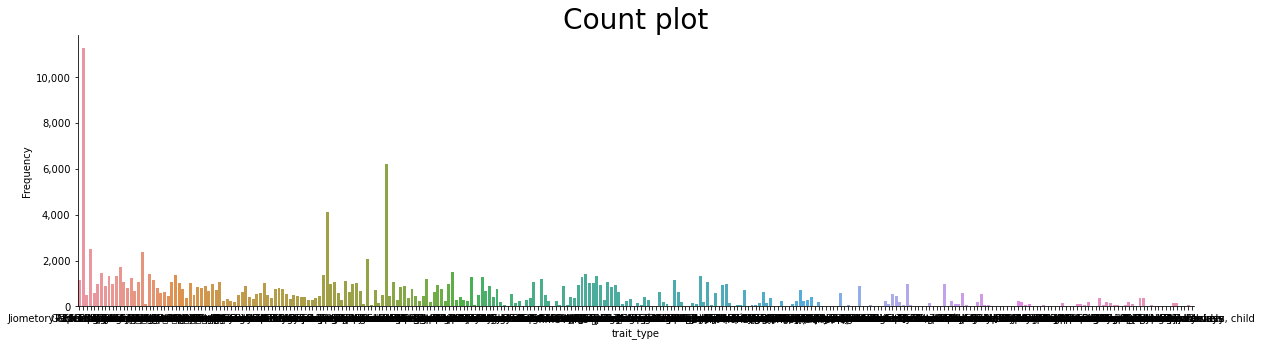

In [63]:
barchar_bucket(df_sales_final,'trait_type')

In [64]:
def histo_plot(ds,n,p,b,cols=list):

    # Identify all numeric variables in the dataset
    numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

    # Draw
    fig, ax = plt.subplots(n,p, figsize=(18,4))
    for var, subplot in zip(ds[cols], ax.flatten()):
        g = sns.histplot(data=ds,
                    bins=b,
                     x=var,
                     ax=subplot,
                     kde=True)

    # Decoration
    sns.despine()
    plt.rc('axes', labelsize=subPlots_label_fontSize)
    fig.suptitle("Histograms of all premium variables", fontsize=plots_Title_fontSize)

In [65]:
# Violin Plot
def violin_plot(ds,cols,hue_col,width,height, hue=False):

    for var in cols:
        if hue is False:
            fig = px.violin(ds, y=var, box=True, points= False)
        else:
            fig = px.violin(ds, y=var, box=True, points= False, color=hue_col)

        fig.update_layout(height=height, width=width, title_text='Violin Plot of '+ var, template = "plotly_white")
        fig.show()
        

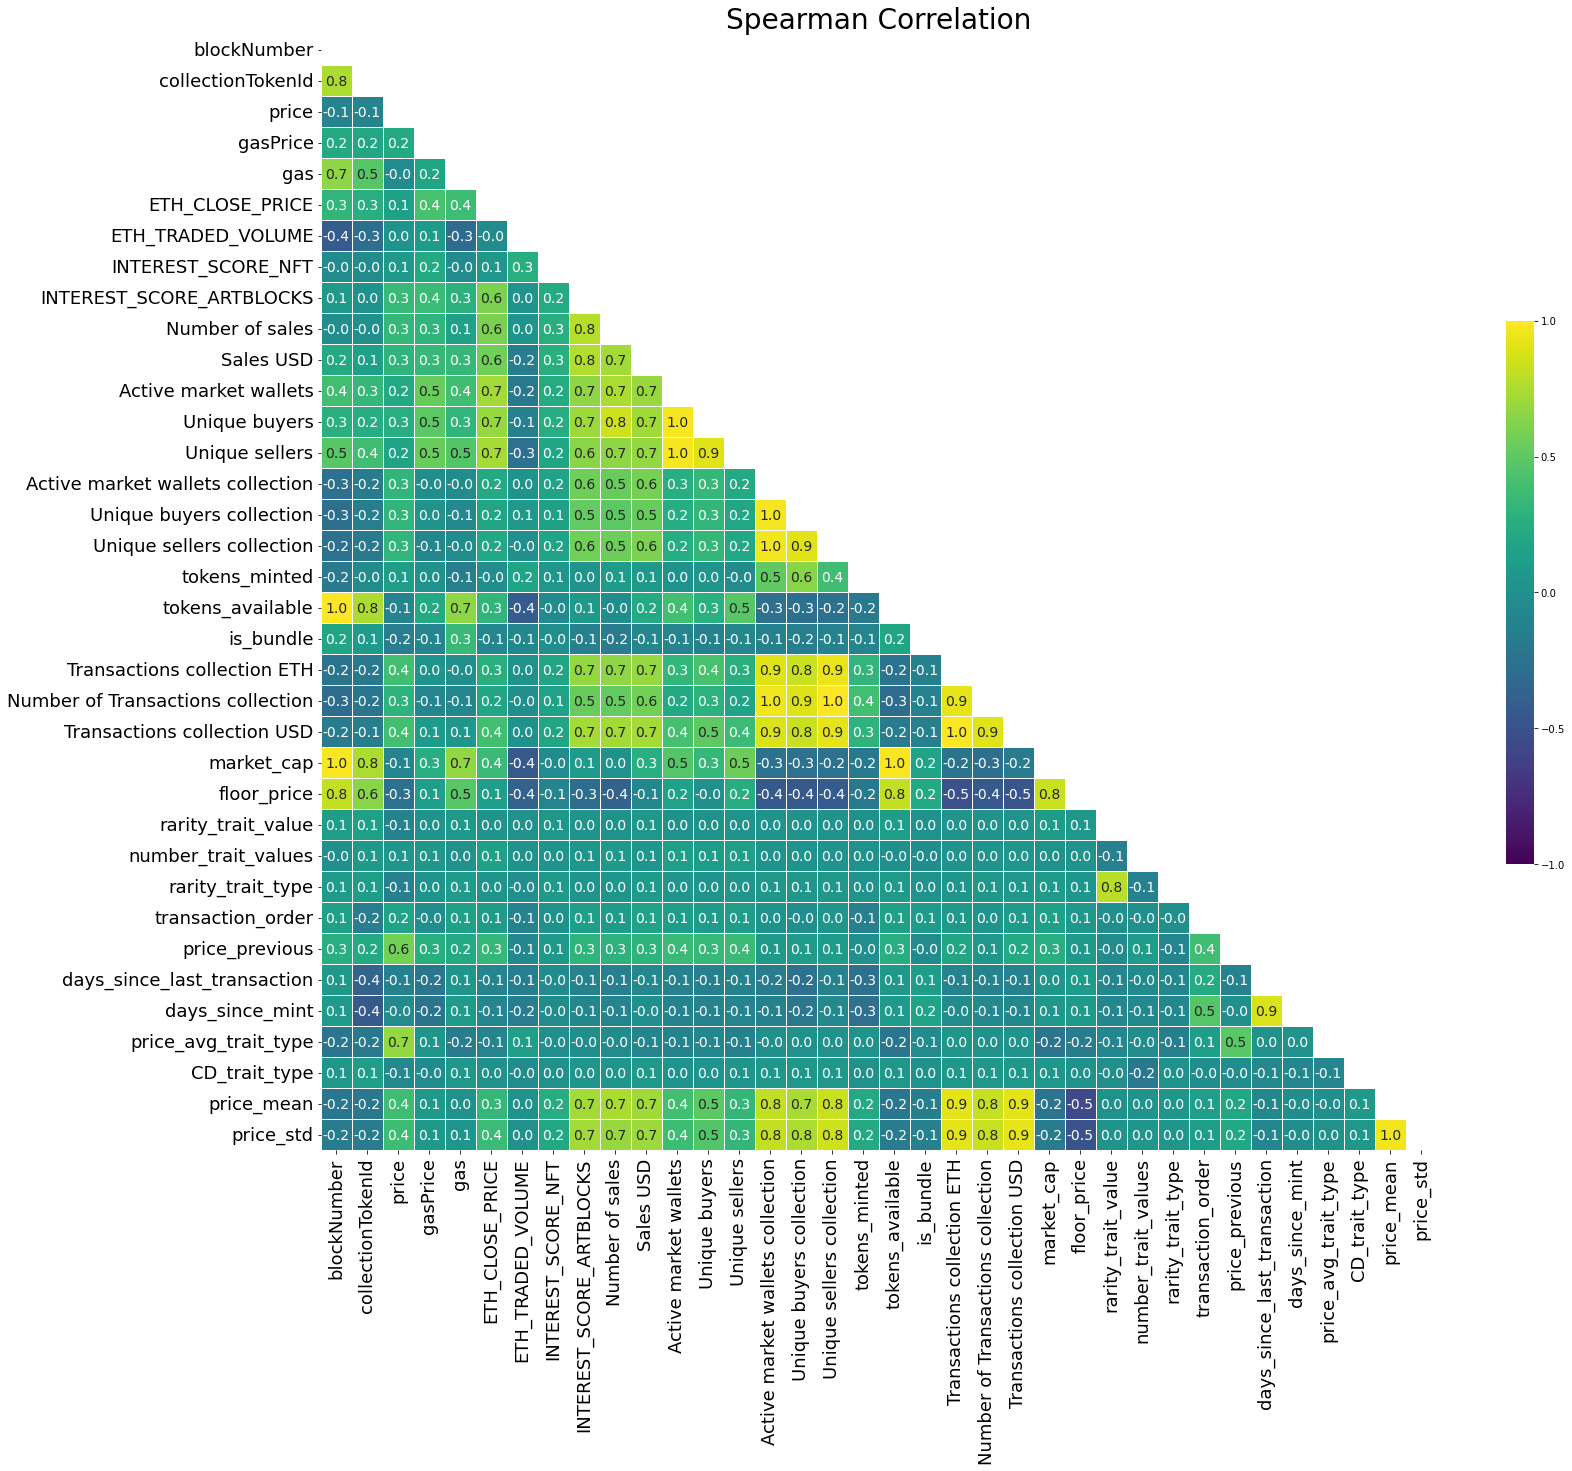

In [66]:
# CORRELATION

# Create correlation matrix
corr = df_sales_final.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(25, 25))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'viridis',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.1f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman Correlation", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0, fontsize=18)
ax.set_xticklabels(corr.columns, rotation = 90, fontsize=18)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [67]:
# Get correlated features
c = df_sales_final.corr(method='spearman').abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so = so[so > 0.5]
so.sort_values(ascending=False,inplace=True)
df_so = pd.DataFrame(so)
df_so = df_so.reset_index()
df_so = df_so[df_so['level_0']!=df_so['level_1']]
df_so.drop_duplicates(subset=[0],inplace=True)
df_so

,level_0,level_1,0
36,blockNumber,tokens_available,0.999936
38,Number of Transactions collection,Unique sellers collection,0.992600
40,Transactions collection USD,Transactions collection ETH,0.987200
42,market_cap,tokens_available,0.978549
44,blockNumber,market_cap,0.978486
...,...,...,...
220,Unique buyers collection,INTEREST_SCORE_ARTBLOCKS,0.522614
222,Number of sales,Number of Transactions collection,0.517899
224,tokens_minted,Active market wallets collection,0.513769
226,floor_price,Transactions collection ETH,0.511297


In [68]:
'''# CORRELATION

# Create correlation matrix
corr = df_model_final.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(25, 25))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'viridis',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.1f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman Correlation", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0, fontsize=18)
ax.set_xticklabels(corr.columns, rotation = 90, fontsize=18)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})'''

'# CORRELATION\n\n# Create correlation matrix\ncorr = df_model_final.corr(method=\'spearman\')\nmask = np.zeros_like(corr, dtype=np.bool)\nmask[np.triu_indices_from(mask)]= True\n\n# Draw\nfig , ax = plt.subplots(figsize=(25, 25))\nheatmap = sns.heatmap(corr,\n                      mask = mask,\n                      square = True,\n                      linewidths = .5,\n                      cmap = \'viridis\',\n                      cbar_kws = {\'shrink\': .4,\n                                \'ticks\' : [-1, -.5, 0, 0.5, 1]},\n                      fmt=\'.1f\',\n                      vmin = -1,\n                      vmax = 1,\n                      annot = True,\n                      annot_kws = {\'size\': heatmaps_text_fontSize})\n\n# Decoration\nplt.title("Spearman Correlation", fontsize=plots_Title_fontSize)\nax.set_yticklabels(corr.columns, rotation = 0, fontsize=18)\nax.set_xticklabels(corr.columns, rotation = 90, fontsize=18)\nsns.set_style({\'xtick.bottom\': True}, {\'ytic

In [69]:
def scatter_matrix(title,ds,cols,hue_col,hue=False):
    
    if hue is False:
        fig = px.scatter_matrix(ds,dimensions=cols)        
    else:
        fig = px.scatter_matrix(ds,dimensions=cols,color=hue_col)
    
    fig.update_layout(height=1200, width=1200, title_text='Scatter Matrix - '+title)#, template = "plotly_white")
    fig.show()

In [70]:
df_sales_final.columns

Index(['blockNumber', 'DATETIME', 'from', 'to', 'txHash', 'collectionTokenId',
       'hash', 'price', 'gasPrice', 'gas', 'DATE', 'ETH_CLOSE_PRICE',
       'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT', 'INTEREST_SCORE_ARTBLOCKS',
       'Number of sales', 'Sales USD', 'Active market wallets',
       'Unique buyers', 'Unique sellers', 'Active market wallets collection',
       'Unique buyers collection', 'Unique sellers collection',
       'tokens_minted', 'tokens_available', 'Action', 'is_bundle',
       'Transactions collection ETH', 'Number of Transactions collection',
       'Transactions collection USD', 'market_cap', 'floor_price',
       'trait_type', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'transaction_order', 'price_previous',
       'days_since_last_transaction', 'days_since_mint',
       'price_avg_trait_type', 'CD_trait_type', 'price_mean', 'price_std'],
      dtype='object')

## Feature Selection

In [71]:
# Add date features
df_sales_final['DATE_WEEKDAY'] = df_sales_final['DATE'].dt.weekday
df_sales_final['DATE_MONTH'] = df_sales_final['DATE'].dt.month
df_sales_final['DATE_YEAR'] = df_sales_final['DATE'].dt.year

final_columns =  ['DATE_WEEKDAY','DATE_MONTH','DATE_YEAR','DATEYEAR','DATE','CD_trait_type',
                  'INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','price', 'gasPrice',
                  'tokens_available','ETH_TRADED_VOLUME','ETH_CLOSE_PRICE','Sales USD','Active market wallets', #delta
                 'Transactions collection USD','Unique buyers collection','Unique sellers collection', #delta
                 'rarity_trait_value', 'number_trait_values','rarity_trait_type','trait_type',
                 'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers', 'Unique sellers'
                 ,'is_bundle','transaction_order', 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
                 , 'floor_price', 'market_cap','price_mean','price_std']

delta_cols = ['ETH_TRADED_VOLUME','ETH_CLOSE_PRICE','Sales USD','Active market wallets', #delta
                 'Transactions collection USD','Unique buyers collection','Unique sellers collection','tokens_available',
             'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers','Unique sellers'
             , 'floor_price', 'market_cap']

In [72]:
df_sales_final['DATEYEAR'] = df_sales_final['DATE_YEAR']
df_model = df_sales_final[final_columns]
df_model.sort_values(by='DATE',inplace=True)


# Add year dummies
df_model = pd.get_dummies(df_model, columns=['DATE_YEAR'])

## Get delta data
df_delta = df_model[['DATE'] + delta_cols].drop_duplicates()
df_delta.sort_values(by='DATE',inplace=True)

df_delta_1 = df_delta.copy()
df_delta_1.index = df_delta_1.DATE 

df_delta_1 = df_delta_1.shift(periods=1)
df_delta_1.DATE = df_delta_1.index
df_delta_1.reset_index(drop=True,inplace=True)

df_delta = df_delta.merge(df_delta_1, how='left', on=['DATE'], suffixes=('', '_1'),indicator=False)
#df_delta.fillna(0,inplace=True)

deltas = []
for col in delta_cols:
    deltas.append(col+'_DELTA')
        
    for i in range(0,df_delta.index.max()+1):
        #print(i,col)
        t = df_delta.loc[i,col]
        t_1 = df_delta.loc[i,col+'_1']
        if i==0:
            pass
        else:
            df_delta.loc[i,col+'_DELTA'] = (t - t_1)/t_1
            

# Add deltas to main dataset
df_model_ = df_model.merge(df_delta[['DATE']+deltas], how='left', on=['DATE'], suffixes=('', ''),indicator=False)
df_model_.dropna(inplace=True)
df_model_.sort_values(by='DATE',inplace=True)

# Filter the deltas
final_columns_ =  ['DATE_WEEKDAY','DATE_MONTH','DATE','DATEYEAR','DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022',
                  'INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','price', 'gasPrice','is_bundle',
                 'rarity_trait_value', 'number_trait_values','rarity_trait_type'
                  ,'transaction_order', 'price_previous','days_since_last_transaction', 'days_since_mint',
                   'price_avg_trait_type', 'floor_price', 'market_cap'
                  ] + deltas
df_model_final = df_model_[final_columns_]
df_model_final.sort_values(by='DATE',inplace=True)

In [73]:
df_model

,DATE_WEEKDAY,DATE_MONTH,DATEYEAR,DATE,CD_trait_type,INTEREST_SCORE_NFT,INTEREST_SCORE_ARTBLOCKS,price,gasPrice,tokens_available,...,days_since_last_transaction,days_since_mint,price_avg_trait_type,floor_price,market_cap,price_mean,price_std,DATE_YEAR_2020,DATE_YEAR_2021,DATE_YEAR_2022
64539,6,12,2020,2020-12-13,77.0,10.5,33.0,0.490000,6.300000e-08,5761.0,...,0,0,2.305096,0.000,5.504244e+07,0.000000,0.000000,1,0,0
64721,6,12,2020,2020-12-13,77.0,10.5,33.0,0.199560,8.880000e-08,5761.0,...,0,0,2.305096,0.000,5.504244e+07,0.000000,0.000000,1,0,0
64744,6,12,2020,2020-12-13,77.0,10.5,33.0,0.220000,5.200000e-08,5761.0,...,0,0,2.305096,0.000,5.504244e+07,0.000000,0.000000,1,0,0
64473,6,12,2020,2020-12-13,77.0,10.5,33.0,0.063737,3.400000e-08,5761.0,...,0,0,2.305096,0.000,5.504244e+07,0.000000,0.000000,1,0,0
64746,6,12,2020,2020-12-13,77.0,10.5,33.0,0.120000,5.100000e-08,5761.0,...,0,0,2.305096,0.000,5.504244e+07,0.000000,0.000000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14077,3,6,2022,2022-06-30,26.0,22.0,21.0,0.748450,5.963965e-08,188401.0,...,219,226,0.756898,0.031,2.321630e+10,300.015971,216.542121,0,0,1
49575,3,6,2022,2022-06-30,166.0,22.0,21.0,0.150000,2.947805e-08,188401.0,...,32,32,1.381574,0.031,2.321630e+10,300.015971,216.542121,0,0,1
47845,3,6,2022,2022-06-30,166.0,22.0,21.0,0.180000,6.975161e-08,188401.0,...,84,84,1.381574,0.031,2.321630e+10,300.015971,216.542121,0,0,1
63236,3,6,2022,2022-06-30,247.0,22.0,21.0,1.400000,4.604667e-08,188401.0,...,335,450,2.004576,0.031,2.321630e+10,300.015971,216.542121,0,0,1


In [74]:
df_model_final

,DATE_WEEKDAY,DATE_MONTH,DATE,DATEYEAR,DATE_YEAR_2020,DATE_YEAR_2021,DATE_YEAR_2022,INTEREST_SCORE_NFT,INTEREST_SCORE_ARTBLOCKS,price,...,Unique buyers collection_DELTA,Unique sellers collection_DELTA,tokens_available_DELTA,Number of Transactions collection_DELTA,Active market wallets collection_DELTA,Number of sales_DELTA,Unique buyers_DELTA,Unique sellers_DELTA,floor_price_DELTA,market_cap_DELTA
97748,0,11,2021-11-08,2021,0,1,0,26.0,73.0,11.1000,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
97751,0,11,2021-11-08,2021,0,1,0,26.0,73.0,0.0050,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
97752,0,11,2021-11-08,2021,0,1,0,26.0,73.0,1.0000,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
97753,0,11,2021-11-08,2021,0,1,0,26.0,73.0,0.3861,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
97754,0,11,2021-11-08,2021,0,1,0,26.0,73.0,0.6000,...,9.227642,4.094828,0.007723,5.988636,4.851064,0.068155,-0.030786,-0.110605,inf,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148887,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.1500,...,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688,0.0,0.044988
148888,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.1800,...,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688,0.0,0.044988
148836,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.1900,...,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688,0.0,0.044988
148784,3,6,2022-06-30,2022,0,0,1,22.0,21.0,0.5000,...,-0.643678,-0.520349,0.001313,-0.690751,-0.522857,-0.094595,-0.025663,0.055688,0.0,0.044988


_________

## Modeling

### OLS

In [75]:
# No delta variables
df_ols = df_model.copy()
df_ols['ln_price'] = np.log(df_ols['price'])


Y = df_ols['ln_price']

X = df_ols[['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME', 'ETH_CLOSE_PRICE',
       'Sales USD', 'Active market wallets', 
       'Transactions collection USD', 'Unique buyers collection',
            'Number of Transactions collection','Active market wallets collection','Number of sales','Unique buyers', 'Unique sellers', #
       'Unique sellers collection', 'tokens_available',
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle'
            , 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
           ]]


X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

predictions = results.predict(X)
df_pred = pd.DataFrame(predictions)
df_pred.rename(columns={0: "y_hat"},inplace=True)
df_pred['y'] = Y
df_pred

mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
print('MAPE: ', mape)
print('MAE: ', mae)
print('MSE: ', mse)

results.summary()


MAPE:  56528335239374.29
MAE:  0.9088745001771545
MSE:  1.5435331426594647


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     4019.
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:33:49   Log-Likelihood:            -2.4358e+05
No. Observations:              148891   AIC:                         4.872e+05
Df Residuals:                  148865   BIC:                         4.875e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -1.3628      0.031    -43.395      0.000      -1.424      -1.301
INTEREST_SCORE_NFT                   -0.0019      0.000     -4.141      0.000      -0.003      -0.001
INTEREST_SCORE_ARTBLOCKS              0.0143      0.000     41.225      0.000       0.014       0.015
gasPrice                           3.433e-07   4.28e-09     80.264      0.000    3.35e-07    3.52e-07
rarity_trait_value                    7.4335      0.095     77.876      0.000       7.246       7.621
number_trait_values                   0.0226      0.000     45.873      0.000       0.022       0.024
rarity_trait_type                    -0.7737      0.008    -92.347      0.000      -0.790      -0.757
ETH_TRADED_VOLUME                 -1.594e-12   6.54e-13     -2.438      0.015   -2.88e-12   -3.12e-13
ETH_CLOSE_PRICE                      -0.0002   8.85e-06    -21.627      0.000      -0.000      -0.000
Sales USD                          1.321e-09   7.16e-11     18.443      0.000    1.18e-09    1.46e-09
Active market wallets             -3.364e-05   5.07e-06     -6.634      0.000   -4.36e-05   -2.37e-05
Transactions collection USD       -7.947e-09   7.63e-10    -10.410      0.000   -9.44e-09   -6.45e-09
Unique buyers collection              0.0007   3.44e-05     21.135      0.000       0.001       0.001
Number of Transactions collection    -0.0008    1.8e-05    -41.633      0.000      -0.001      -0.001
Active market wallets collection     -0.0008   4.78e-05    -16.021      0.000      -0.001      -0.001
Number of sales                    5.824e-06   2.74e-07     21.246      0.000    5.29e-06    6.36e-06
Unique buyers                      3.048e-05   4.94e-06      6.170      0.000    2.08e-05    4.02e-05
Unique sellers                     1.383e-05   3.81e-06      3.629      0.000    6.36e-06    2.13e-05
Unique sellers collection             0.0021   6.33e-05     32.827      0.000       0.002       0.002
tokens_available                  -1.292e-06   2.01e-07     -6.414      0.000   -1.69e-06   -8.97e-07
DATE_YEAR_2020                       -1.1764      0.082    -14.350      0.000      -1.337      -1.016
DATE_YEAR_2021                       -0.1953      0.030     -6.573      0.000      -0.254      -0.137
DATE_YEAR_2022                        0.0089      0.032      0.275      0.783      -0.054       0.072
is_bundle                            -1.6383      0.017    -96.722      0.000      -1.671      -1.605
price_previous                        0.0337      0.001     40.603      0.000       0.032       0.035
days_since_last_transaction          -0.0034   9.47e-05    -35.409      0.000      -0.004      -0.003
days_since_mint                       0.0036   7.74e-05     45.946      0.000       0.003       0.004
price_avg_trait_type   

In [76]:
# both delta and non delta variables
df_ols = df_model_.copy()
df_ols['ln_price'] = np.log(df_ols['price'])


Y = df_ols['ln_price']
X = df_ols[['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME_DELTA', 'ETH_CLOSE_PRICE_DELTA',
       'Sales USD_DELTA', 'Active market wallets_DELTA',
       'Transactions collection USD_DELTA', 'Unique buyers collection_DELTA',
       'Unique sellers collection_DELTA', 'tokens_available_DELTA',
    'Number of Transactions collection_DELTA','Active market wallets collection_DELTA','Number of sales_DELTA','Unique buyers_DELTA', 'Unique sellers_DELTA', #
        'ETH_TRADED_VOLUME', 'ETH_CLOSE_PRICE',
       'Sales USD', 'Active market wallets', 
       'Transactions collection USD', 'Unique buyers collection',
       'Unique sellers collection', 'tokens_available' ,  
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle',
             'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
           ]]


X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

predictions = results.predict(X)
df_pred = pd.DataFrame(predictions)
df_pred.rename(columns={0: "y_hat"},inplace=True)
df_pred['y'] = Y
df_pred

mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
print('MAPE: ', mape)
print('MAE: ', mae)
print('MSE: ', mse)

results.summary()

MAPE:  57095129192976.516
MAE:  0.9404663633841082
MSE:  1.8072458819678712


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     772.0
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:33:50   Log-Likelihood:                -87702.
No. Observations:               51143   AIC:                         1.755e+05
Df Residuals:                   51110   BIC:                         1.758e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -3.4821      0.296    -11.752      0.000      -4.063      -2.901
INTEREST_SCORE_NFT                          0.0002      0.001      0.269      0.788      -0.001       0.002
INTEREST_SCORE_ARTBLOCKS                    0.0122      0.001     14.663      0.000       0.011       0.014
gasPrice                                -7.908e-06   9.31e-06     -0.849      0.396   -2.62e-05    1.03e-05
rarity_trait_value                          5.8671      0.231     25.351      0.000       5.413       6.321
number_trait_values                         0.0281      0.001     41.270      0.000       0.027       0.029
rarity_trait_type                          -0.5652      0.023    -24.070      0.000      -0.611      -0.519
ETH_TRADED_VOLUME_DELTA                     0.1432      0.025      5.781      0.000       0.095       0.192
ETH_CLOSE_PRICE_DELTA                       0.6122      0.161      3.800      0.000       0.296       0.928
Sales USD_DELTA                            -0.2327      0.023    -10.307      0.000      -0.277      -0.188
Active market wallets_DELTA                 0.3025      0.436      0.695      0.487      -0.551       1.156
Transactions collection USD_DELTA           0.0644      0.003     21.650      0.000       0.059       0.070
Unique buyers collection_DELTA              0.0007      0.015      0.043      0.966      -0.029       0.031
Unique sellers collection_DELTA             0.0831      0.035      2.363      0.018       0.014       0.152
tokens_available_DELTA                      4.5216      6.363      0.711      0.477      -7.951      16.994
Number of Transactions collection_DELTA    -0.1767      0.016    -11.338      0.000      -0.207      -0.146
Active market wallets collection_DELTA      0.0219      0.039      0.561      0.575      -0.055       0.098
Number of sales_DELTA                       0.1962      0.087      2.261      0.024       0.026       0.366
Unique buyers_DELTA                         0.0571      0.253      0.226      0.821      -0.438       0.552
Unique sellers_DELTA                       -0.4868      0.199     -2.445      0.014      -0.877      -0.097
ETH_TRADED_VOLUME                        9.571e-12    1.4e-12      6.851      0.000    6.83e-12    1.23e-11
ETH_CLOSE_PRICE                            -0.0002   1.89e-05    -12.330      0.000      -0.000      -0.000
Sales USD                                2.932e-09   2.14e-10     13.720      0.000    2.51e-09    3.35e-09
Active market wallets                    8.182e-06   9.83e-07      8.327      0.000    6.26e-06    1.01e-05
Transactions collection USD              1.658e-07    6.9e-09     24.033      0.000    1.52e-07    1.79e-07
Unique buyers collection                    0.0005   7.27e-

In [77]:
# Only delta variables

df_ols = df_model_final.copy()
df_ols['ln_price'] = np.log(df_ols['price'])


Y = df_ols['ln_price']
X = df_ols[['INTEREST_SCORE_NFT','INTEREST_SCORE_ARTBLOCKS','gasPrice', 'rarity_trait_value', 'number_trait_values',
       'rarity_trait_type', 'ETH_TRADED_VOLUME_DELTA', 'ETH_CLOSE_PRICE_DELTA',
       'Sales USD_DELTA', 'Active market wallets_DELTA',
    'Number of Transactions collection_DELTA','Active market wallets collection_DELTA','Number of sales_DELTA','Unique buyers_DELTA', 'Unique sellers_DELTA', #            
       'Transactions collection USD_DELTA', 'Unique buyers collection_DELTA',
       'Unique sellers collection_DELTA', 'tokens_available_DELTA',
           'DATE_YEAR_2020', 'DATE_YEAR_2021', 'DATE_YEAR_2022','is_bundle'
            , 'price_previous','days_since_last_transaction', 'days_since_mint','price_avg_trait_type'
           ]]


X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

predictions = results.predict(X)
df_pred = pd.DataFrame(predictions)
df_pred.rename(columns={0: "y_hat"},inplace=True)
df_pred['y'] = Y
df_pred

mape = mean_absolute_percentage_error(df_pred['y'], df_pred['y_hat'])
mae = mean_absolute_error(df_pred['y'], df_pred['y_hat'])
mse = mean_squared_error(df_pred['y'], df_pred['y_hat'])
print('MAPE: ', mape)
print('MAE: ', mae)
print('MSE: ', mse)

results.summary()

MAPE:  55569032487666.35
MAE:  0.9502408824423219
MSE:  1.8647149480479892


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     894.8
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:33:50   Log-Likelihood:                -88503.
No. Observations:               51143   AIC:                         1.771e+05
Df Residuals:                   51117   BIC:                         1.773e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -1.6561      0.022    -73.856      0.000      -1.700      -1.612
INTEREST_SCORE_NFT                          0.0055      0.001      9.602      0.000       0.004       0.007
INTEREST_SCORE_ARTBLOCKS                    0.0144      0.001     22.401      0.000       0.013       0.016
gasPrice                                 9.246e+05    7.5e+04     12.334      0.000    7.78e+05    1.07e+06
rarity_trait_value                          6.6195      0.230     28.731      0.000       6.168       7.071
number_trait_values                         0.0299      0.001     43.972      0.000       0.029       0.031
rarity_trait_type                          -0.6151      0.024    -26.074      0.000      -0.661      -0.569
ETH_TRADED_VOLUME_DELTA                     0.2154      0.022      9.972      0.000       0.173       0.258
ETH_CLOSE_PRICE_DELTA                       0.2349      0.160      1.472      0.141      -0.078       0.548
Sales USD_DELTA                             0.0412      0.015      2.738      0.006       0.012       0.071
Active market wallets_DELTA                -1.0851      0.426     -2.545      0.011      -1.921      -0.249
Number of Transactions collection_DELTA    -0.3871      0.014    -27.819      0.000      -0.414      -0.360
Active market wallets collection_DELTA      0.1445      0.039      3.724      0.000       0.068       0.221
Number of sales_DELTA                       0.6390      0.085      7.517      0.000       0.472       0.806
Unique buyers_DELTA                         0.5318      0.249      2.138      0.033       0.044       1.019
Unique sellers_DELTA                       -0.6616      0.195     -3.392      0.001      -1.044      -0.279
Transactions collection USD_DELTA           0.0860      0.003     31.672      0.000       0.081       0.091
Unique buyers collection_DELTA             -0.0552      0.014     -3.813      0.000      -0.084      -0.027
Unique sellers collection_DELTA             0.4183      0.033     12.727      0.000       0.354       0.483
tokens_available_DELTA                     44.4634      2.605     17.069      0.000      39.358      49.569
DATE_YEAR_2020                          -2.102e-06    1.7e-07    -12.334      0.000   -2.44e-06   -1.77e-06
DATE_YEAR_2021                             -1.0370      0.016    -63.052      0.000      -1.069      -1.005
DATE_YEAR_2022                             -0.6208      0.011    -56.445      0.000      -0.642      -0.599
is_bundle                                  -1.1251      0.021    -53.194      0.000      -1.167      -1.084
price_previous                             -0.0093      0.001     -7.696      0.000      -0.012      -0.007
days_since_last_transaction                -0.0038      0.0

________________

### Machine Learning

In [78]:
def split_data(df,cols):
    
    df_ = df[cols]
    
    X = df_.drop(columns=['price'])
    y = df_['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=16)#, stratify=X['DATEYEAR'])
    
    #X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=16, stratify=X_test_['DATEYEAR'])
    
    return df_, X, y, X_train, X_test, y_train, y_test#, X_val, y_val

In [79]:
from sklearn.model_selection import TimeSeriesSplit

def split_ts(df,cols):
    
    df_ = df[cols]

    test_size = int(round(len(df_)*0.20,0))
    size = int(len(df_) - test_size)
    test = df_.iloc[-test_size:]
    train = df_.iloc[:size]

    
    X_train = train.drop(columns=['price'])
    X_test = test.drop(columns=['price'])
    y_train = train['price']
    y_test = test['price']
    
    #X_train.reset_index(drop=True,inplace=True)
    #X_test.reset_index(drop=True,inplace=True)
    #y_train.reset_index(drop=True,inplace=True)
    #y_test.reset_index(drop=True,inplace=True)
    
        
    return df_, X_train, X_test, y_train, y_test#, X_val, y_val

In [80]:
cols = ['DATE_WEEKDAY', 'DATE_MONTH','DATEYEAR','CD_trait_type',
       'INTEREST_SCORE_NFT', 'INTEREST_SCORE_ARTBLOCKS', 'price', 'gasPrice',
       'tokens_available', 'ETH_TRADED_VOLUME', 'ETH_CLOSE_PRICE', 'Sales USD',
       'Active market wallets', 'Transactions collection USD',
       'Unique buyers collection', 'Unique sellers collection',
       'rarity_trait_value', 'number_trait_values', 'rarity_trait_type',
       'Number of Transactions collection',
       'Active market wallets collection', 'Number of sales', 'Unique buyers',
       'Unique sellers', 'is_bundle', 'transaction_order', 'price_previous',
       'days_since_last_transaction', 'days_since_mint','floor_price','market_cap',
       'price_avg_trait_type']

df_model.reset_index(drop=True,inplace=True)
#df_model_ml, X, y, X_train, X_test, y_train, y_test = split_data(df_model,cols)

# Split dataset into 4 folds
n_splits = 4
id_split = round(len(df_model)/n_splits)

split1 = df_model.iloc[:id_split]
split2 = df_model.iloc[id_split:id_split*2]
split3 = df_model.iloc[id_split*2:id_split*3]
split4 = df_model.iloc[id_split*3:]

# Split each set into train and test
#df_model_ml, X_train, X_test, y_train, y_test = split_ts(df_model,cols)

df_model_ml1, X_train1, X_test1, y_train1, y_test1 = split_ts(split1,cols)
df_model_ml2, X_train2, X_test2, y_train2, y_test2 = split_ts(split2,cols)
df_model_ml3, X_train3, X_test3, y_train3, y_test3 = split_ts(split3,cols)
df_model_ml4, X_train4, X_test4, y_train4, y_test4 = split_ts(split4,cols)

In [81]:
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as ltb
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostRegressor

from matplotlib import pyplot
 

In [82]:
# Build class to store models and parameters

from skopt.space import Real, Categorical, Integer


class classification_models:
    def __init__(self):
        self.baseline = self.baseline()
        self.svc = self.svc()
        self.naive_bayes = self.naive_bayes()
        self.knn = self.knn()
        self.logistic_regression = self.logistic_regression()
        self.xgboost = self.xgboost()
        self.ada = self.ada()
        self.lgb = self.lgb()
        self.dt = self.dt()
        self.rf = self.rf()



class knn:
    model = KNeighborsRegressor()

    parameters = {'model__n_neighbors': Integer(3, 100),
                  'model__weights': Categorical(categories=['uniform', 'distance']),
                  'model__algorithm': Categorical(categories=['auto', 'ball_tree', 'kd_tree', 'brute']),
                  'model__leaf_size': Integer(5, 50)
                  }

    @staticmethod
    def best_model(params):
        clf = KNeighborsRegressor()
        return clf

    
class dt:
    model = DecisionTreeRegressor()

    parameters = {
                   'model__max_depth': Integer(2, 100),
                   'model__min_samples_leaf': Integer(2, 100),
                   'model__min_samples_split': Integer(2, 100),
                   'model__random_state': [16],
                 }

    @staticmethod
    def best_model(params):
        clf = DecisionTreeRegressor()
        return clf   
    
    
class rf:
    model = RandomForestRegressor()

    parameters = {
                   'model__max_depth': Integer(2, 100),
                   'model__min_samples_leaf': Integer(2, 100),
                   'model__min_samples_split': Integer(2, 100),
                   'model__n_estimators': Integer(10, 500),
                   'model__random_state': [16],
                 }

    @staticmethod
    def best_model(params):
        clf = RandomForestRegressor()
        return clf    


class xgboost:
    model = xgb.XGBRegressor()

    parameters = {
                   'model__learning_rate': Real(0.01,1.0,'uniform'),
                   'model__max_depth': Integer(2, 100),
                   'model__min_samples_leaf': Integer(2, 100),
                   'model__min_samples_split': Integer(2, 100),
                   'model__subsample': Real(0.1,1.0,'uniform'),
                   'model__n_estimators': Integer(10, 250),
                   'model__random_state': [16],
                 }


    @staticmethod
    def best_model(params):
        clf = xgb.XGBRegressor(**params)
        return clf


class ada:
    model = AdaBoostRegressor()

    parameters = {
                   'model__learning_rate': Real(0.01,1.0,'uniform'),
                   'model__n_estimators': Integer(10, 500),
                   'model__random_state': [16],
                 }


    @staticmethod
    def best_model(params):
        clf = AdaBoostRegressor(**params)
        return clf
    
class lgb:
    model = ltb.LGBMRegressor()

    parameters = {
                   'model__learning_rate': Real(0.01,1.0,'uniform'),
                   'model__max_depth': Integer(2, 100),
                   'model__min_samples_leaf': Integer(2, 100),
                   'model__min_samples_split': Integer(2, 100),
                   'model__subsample': Real(0.1,1.0,'uniform'),
                   'model__n_estimators': Integer(10, 500),
                   'model__random_state': [16],
                 }


    @staticmethod
    def best_model(params):
        clf = ltb.LGBMRegressor(**params)
        return clf

In [83]:
# Function to build models
def build_model(X,y,niter,model_list=list):
    '''model_list = [baseline, svc, naive_bayes, knn, logistic_regression, xgboost]'''
    gsearchs = []
    best_models = []
    scores = []
    best_params = []
    cv_results = []
    
    print('---------------- MODEL TRAINING ----------------')
    
    for i in model_list:
        
        string = str(i)
        model_name_ = string[string.find('.')+1:]
        model_name = model_name_[0:model_name_.find('>')-1].strip()       
        print('\nModel: ', model_name)
        
        # Get model
        model = i.model
        
        # Import RFE
        #select = RFE(model, n_features_to_select=5, step=1)
        if model_name in ['rf', 'ada', 'xgboost']:
            select = RFECV(estimator=DecisionTreeRegressor(), step=1, min_features_to_select=10,scoring='neg_mean_squared_error')
        else:
            select = RFECV(model, min_features_to_select=10,scoring='neg_mean_squared_error')
        #select = SelectKBest(f_classif, k=10)
        
        # Create pipeline
        pipe = Pipeline([('scaler', MinMaxScaler()),('selector', select),('model',model)])
        #pipe = Pipeline([('scaler', MinMaxScaler()),('model',model)])
        #pipe = Pipeline([('model',model)])
    
        # Get hyperparameter grid
        param_search = i.parameters
        
        # Stratified k-fold cross-validation
        #skf = StratifiedKFold(n_splits=5)
        #skf = KFold(n_splits=8)
        skf = TimeSeriesSplit(n_splits=6)
        my_cv = [(train,test) for train, test in skf.split(X,y)]
        
        gsearch = BayesSearchCV(pipe, cv=skf, search_spaces=param_search, n_jobs=-1,scoring='neg_mean_squared_error',
                                     verbose=True,refit=True,n_iter=niter)
        
        
        gsearch.fit(X, y)
        
        
        gsearchs.append(gsearch)
        best_models.append(gsearch.best_estimator_)
        scores.append(gsearch.best_score_)
        best_params.append(gsearch.best_params_)
        cv_results.append(gsearch.cv_results_)
        
        print('CV accuracy for model {0}: {1}'.format(model_name,gsearch.best_score_))
        
    return gsearchs,best_models,scores,best_params,cv_results

In [84]:
model_list = [xgboost, dt, rf, lgb]#, xgboost]
gsearchs1,best_models1,scores1,best_params1,cv_results1 = build_model(X_train1,y_train1, 50,model_list)
gsearchs2,best_models2,scores2,best_params2,cv_results2 = build_model(X_train2,y_train2, 50,model_list)
gsearchs3,best_models3,scores3,best_params3,cv_results3 = build_model(X_train3,y_train3, 50,model_list)
gsearchs4,best_models4,scores4,best_params4,cv_results4 = build_model(X_train4,y_train4, 50,model_list)

---------------- MODEL TRAINING ----------------

Model:  xgboost
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalli

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
CV accuracy for model lgb: -102.08734501765083
---------------- MODEL TRAINING ----------------

Model:  xgboost
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fi

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fi

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
CV accuracy for model lgb: -12.959666222113254


In [85]:
# Get best model feature stats
def get_features(gsearchs):
    ad = []
    for i in range(0,len(gsearchs)):
        #print(gsearchs[1])
        print(i)
        d = {'support': gsearchs[i].best_estimator_['selector'].get_support(indices=False),
            'ranking': gsearchs[i].best_estimator_['selector'].ranking_
            }

        selected_features = pd.DataFrame(d, index = X_train1.columns)
        selected_features.sort_values(by=['ranking'],inplace = True)
        selected_features['model'] = i

        print('Number of Features: ', [gsearchs[i].best_estimator_['selector'].n_features_in_])
        print('Number of Features in: ', [gsearchs[i].best_estimator_['selector'].n_features_])
        print('Features in: ', selected_features[selected_features['support']==True].index.tolist())

        ad.append(selected_features)
        print('______________________________________________________________________')

    features = pd.concat(ad)

    return features

features1 = get_features(gsearchs1)
features2 = get_features(gsearchs2)
features3 = get_features(gsearchs3)
features4 = get_features(gsearchs4)

0
Number of Features:  [31]
Number of Features in:  [18]
Features in:  ['rarity_trait_value', 'days_since_mint', 'days_since_last_transaction', 'price_previous', 'Unique sellers', 'Number of sales', 'rarity_trait_type', 'number_trait_values', 'Unique sellers collection', 'Transactions collection USD', 'Active market wallets', 'price_avg_trait_type', 'ETH_CLOSE_PRICE', 'ETH_TRADED_VOLUME', 'INTEREST_SCORE_NFT', 'tokens_available', 'gasPrice', 'Sales USD']
______________________________________________________________________
1
Number of Features:  [31]
Number of Features in:  [17]
Features in:  ['rarity_trait_value', 'days_since_mint', 'days_since_last_transaction', 'price_previous', 'Unique sellers', 'Number of sales', 'rarity_trait_type', 'number_trait_values', 'Unique sellers collection', 'Transactions collection USD', 'Active market wallets', 'price_avg_trait_type', 'ETH_TRADED_VOLUME', 'tokens_available', 'gasPrice', 'INTEREST_SCORE_NFT', 'Sales USD']
______________________________

In [86]:
gsearchs1[0]

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
              estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                        ('selector',
                                         RFECV(estimator=DecisionTreeRegressor(),
                                               min_features_to_select=10,
                                               scoring='neg_mean_squared_error')),
                                        ('model',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_...
                             'model__min_samples_leaf': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'model__min_samples_split': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'model__n_estimators': Integer(low=10, high=250, prior='uniform', transform='normalize'),
                             'model__random_state': [16],
                             'model__subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize')},
              verbose=True)

In [87]:
print(scores2)

[-100.27422832861502, -97.97694035056435, -96.05644452178059, -102.08734501765083]


In [88]:
### ---------------------------- PERFORMANCE ASSESSEMENT ----------------------------### 
# Function to evaluate models
def evaluate_model(X_test, X_train,y_train, y_test, best_models):
    
    mae_,mse_,mape_,r_,r_adj_,pred_ = list(),list(),list(),list(),list(),list()
    
    print('---------------- MODEL EVALUATION ----------------')
    
    model_counter = 1
    for i in best_models:
        
        string = str(i)
        model_name_ = string[string.find(''''model',''')+len(''''model', '''):]
        model_name = model_name_[0:model_name_.find('(')].strip() 
        print('\nModel #{0}: {1}'.format(model_counter,model_name))
        
        # Predict
        y_pred = i.predict(X_test)        
        df_pred = pd.DataFrame(data=y_pred, columns=['y_hat'],index=y_test.index)
        df_pred['y'] = y_test
        df_pred['model'] = model_name        
        
        # Evaluation metrics     
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r = r2_score(y_test, y_pred)
        #Adj_r2 = 1 - (1-r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y)-X_test.shape[1]-1)
        
        print('MAPE: ', mape)
        print('MAE: ', mae)
        print('MSE: ', mse)  
        print('R2: ', r)

        mae_.append(mae)
        mape_.append(mape)
        mse_.append(mse)
        r_.append(r)
        pred_.append(df_pred)
        
        model_counter+=1
    
    # Get best model based on MSE
    maxi_model_nb = mse_.index(min(mse_))
    
    maxi_model = best_models[maxi_model_nb]
    string_ = str(maxi_model)
    maxi_model_name_ = string_[string_.find(''''model',''')+len(''''model', '''):]
    maxi_model_name = maxi_model_name_[0:maxi_model_name_.find('(')].strip() 
    predictions = pd.concat(pred_)
    
    
    print('\nBest Model: #{0} {1}'.format(maxi_model_nb+1,maxi_model_name))
    
    
    return mae_,mse_,mape_,r_, maxi_model, predictions

In [89]:
mae1,mse1,mape1,r1,maxi_model1, predictions_train1 = evaluate_model(X_train1, X_train1, y_train1, y_train1, best_models1)
mae2,mse2,mape2,r2,maxi_model2, predictions_train2 = evaluate_model(X_train2, X_train2, y_train2, y_train2, best_models2)
mae3,mse3,mape3,r3,maxi_model3, predictions_train3 = evaluate_model(X_train3, X_train3, y_train3, y_train3, best_models3)
mae4,mse4,mape4,r4,maxi_model4, predictions_train4 = evaluate_model(X_train4, X_train4, y_train4, y_train4, best_models4)

---------------- MODEL EVALUATION ----------------

Model #1: XGBRegressor
MAPE:  40.204084694997015
MAE:  0.43009762283082126
MSE:  4.396119368273926
R2:  0.6467087779697671

Model #2: DecisionTreeRegressor
MAPE:  43.653914960205064
MAE:  0.43345735955372383
MSE:  3.3327450121088593
R2:  0.732166153962875

Model #3: RandomForestRegressor
MAPE:  35.5492804369817
MAE:  0.3749372125508269
MSE:  2.927406421568016
R2:  0.7647409213865387

Model #4: LGBMRegressor
MAPE:  48.05466950352376
MAE:  0.5081159747376169
MSE:  3.439042319534621
R2:  0.7236236412390415

Best Model: #3 RandomForestRegressor
---------------- MODEL EVALUATION ----------------

Model #1: XGBRegressor
MAPE:  7.796101399462768
MAE:  0.3802843198435901
MSE:  12.314922457210237
R2:  0.9390275337191911

Model #2: DecisionTreeRegressor
MAPE:  39.40061383939754
MAE:  1.0202556386084534
MSE:  79.53979752778403
R2:  0.6061901616030305

Model #3: RandomForestRegressor
MAPE:  35.51514389460988
MAE:  0.7782500657184431
MSE:  61.5116

In [90]:
print('------------------- TRAIN -------------------')
for i in range(0,len(model_list)):
    print(i,model_list[i])
    mae = (mae1[i]+mae2[i]+mae3[i]+mae4[i])/4
    print('MAE: ',mae)
    mse = (mse1[i]+mse2[i]+mse3[i]+mse4[i])/4
    print('MSE: ',mse)
    mape = (mape1[i]+mape2[i]+mape3[i]+mape4[i])/4
    print('MAPE: ',mape)
    r = (r1[i]+r2[i]+r3[i]+r4[i])/4
    print('R2: ',r)
    print('\n')

------------------- TRAIN -------------------
0 <class '__main__.xgboost'>
MAE:  0.4669622370801508
MSE:  34.80791018716054
MAPE:  16704758434.361063
R2:  0.7796616269086581


1 <class '__main__.dt'>
MAE:  0.7559419283850706
MSE:  67.29938333661656
MAPE:  21610351695.648643
R2:  0.6230442380575593


2 <class '__main__.rf'>
MAE:  1.0011553778130908
MSE:  67.39197404476468
MAPE:  23278542272.645782
R2:  0.644207451824395


3 <class '__main__.lgb'>
MAE:  0.8575954781531181
MSE:  48.653210979715446
MAPE:  35587231342.4958
R2:  0.7304164661809964




In [91]:
predictions_train = pd.concat([predictions_train1,predictions_train2,predictions_train3,predictions_train4])
predictions_train

,y_hat,y,model
0,0.310376,0.490000,XGBRegressor
1,0.317104,0.199560,XGBRegressor
2,0.292345,0.220000,XGBRegressor
3,0.280589,0.063737,XGBRegressor
4,0.269752,0.120000,XGBRegressor
...,...,...,...
141442,0.255130,0.090000,LGBMRegressor
141443,1.696915,1.950000,LGBMRegressor
141444,0.441975,0.230000,LGBMRegressor
141445,0.250861,0.070000,LGBMRegressor


In [92]:
mae1,mse1,mape1,r1,maxi_model1,predictions_test1 = evaluate_model(X_test1, X_train1, y_train1, y_test1, best_models1)
mae2,mse2,mape2,r2,maxi_model2,predictions_test2 = evaluate_model(X_test2, X_train2, y_train2, y_test2, best_models2)
mae3,mse3,mape3,r3,maxi_model3,predictions_test3 = evaluate_model(X_test3, X_train3, y_train3, y_test3, best_models3)
mae4,mse4,mape4,r4,maxi_model4,predictions_test4 = evaluate_model(X_test4, X_train4, y_train4, y_test4, best_models4)

---------------- MODEL EVALUATION ----------------

Model #1: XGBRegressor
MAPE:  40.789342829630094
MAE:  0.7073034347450837
MSE:  8.4275318546566
R2:  0.48542953551641566

Model #2: DecisionTreeRegressor
MAPE:  35.97934954802436
MAE:  0.6579928528257453
MSE:  6.380373036539801
R2:  0.6104254989939041

Model #3: RandomForestRegressor
MAPE:  38.80349296532013
MAE:  0.5749472667658945
MSE:  5.547460328634499
R2:  0.6612817029659239

Model #4: LGBMRegressor
MAPE:  39.46314779327946
MAE:  0.7598474820375196
MSE:  6.310022272445492
R2:  0.6147209945175172

Best Model: #3 RandomForestRegressor
---------------- MODEL EVALUATION ----------------

Model #1: XGBRegressor
MAPE:  672.415751492015
MAE:  3.0622979922068247
MSE:  498.97503670273494
R2:  0.3915265423892068

Model #2: DecisionTreeRegressor
MAPE:  813.1134648284981
MAE:  4.494911164399249
MSE:  633.6415568106727
R2:  0.2273078999978706

Model #3: RandomForestRegressor
MAPE:  827.6768003364405
MAE:  4.183088009081622
MSE:  565.457234775

In [93]:
print('------------------- TEST -------------------')
for i in range(0,len(model_list)):
    print(i,model_list[i])
    mae = (mae1[i]+mae2[i]+mae3[i]+mae4[i])/4
    print('MAE: ',mae)
    mse = (mse1[i]+mse2[i]+mse3[i]+mse4[i])/4
    print('MSE: ',mse)
    mape = (mape1[i]+mape2[i]+mape3[i]+mape4[i])/4
    print('MAPE: ',mape)
    r = (r1[i]+r2[i]+r3[i]+r4[i])/4
    print('R2: ',r)
    print('\n')

------------------- TEST -------------------
0 <class '__main__.xgboost'>
MAE:  1.3757780898438103
MSE:  132.63869909214674
MAPE:  217.81999625229307
R2:  -0.17428779083909968


1 <class '__main__.dt'>
MAE:  1.654209957170392
MSE:  165.32743806619382
MAPE:  245.94050975003353
R2:  -0.11885628105718055


2 <class '__main__.rf'>
MAE:  1.7209882499134144
MSE:  148.8532771760678
MAPE:  290.98912152410213
R2:  -0.3180357071319455


3 <class '__main__.lgb'>
MAE:  1.5599419728324144
MSE:  133.83275636950427
MAPE:  293.8778123660323
R2:  -0.6383352948147583




In [94]:
predictions_test = pd.concat([predictions_test1,predictions_test2,predictions_test3,predictions_test4])
predictions_test

,y_hat,y,model
29778,0.844757,1.10000,XGBRegressor
29779,0.395497,0.45000,XGBRegressor
29780,0.310249,0.25000,XGBRegressor
29781,0.279701,0.14440,XGBRegressor
29782,0.400529,0.30000,XGBRegressor
...,...,...,...
148886,0.398297,0.74845,LGBMRegressor
148887,0.542946,0.15000,LGBMRegressor
148888,0.542946,0.18000,LGBMRegressor
148889,0.989231,1.40000,LGBMRegressor


In [95]:
final_results = pd.concat([predictions_train, predictions_test], ignore_index=False)
#final_results.to_csv('final_results_std_mean_split.csv')
final_results

,y_hat,y,model
0,0.310376,0.490000,XGBRegressor
1,0.317104,0.199560,XGBRegressor
2,0.292345,0.220000,XGBRegressor
3,0.280589,0.063737,XGBRegressor
4,0.269752,0.120000,XGBRegressor
...,...,...,...
148886,0.398297,0.748450,LGBMRegressor
148887,0.542946,0.150000,LGBMRegressor
148888,0.542946,0.180000,LGBMRegressor
148889,0.989231,1.400000,LGBMRegressor


______________________

In [96]:
def get_pred(df_model,predictions_test,lb):
    print('---------------------- ' + lb + '---------------------- ')

    df = df_model[['DATE','floor_price']].merge(predictions_test, how='right', left_index=True, right_index=True,indicator=False)
    df.index = predictions_test.index
    df['set'] = lb
    
    df['y_hat_'] = df['y_hat']
    
    df.reset_index(drop=True,inplace=True)
    for i in df.index.tolist():
        #print(i)
        a = df.loc[i,'y_hat']
        b = df.loc[i,'floor_price']
        
        if a < 0:
            df.loc[i,'y_hat_'] = b
    
    
    # Evaluation metrics
    
    for i in df.model.unique().tolist():
        print(i)
        ddf = df[df['model']==i]
        mape = mean_absolute_percentage_error(ddf['y'], ddf['y_hat_'])
        mae = mean_absolute_error(ddf['y'], ddf['y_hat_'])
        mse = mean_squared_error(ddf['y'], ddf['y_hat_'])
        r = r2_score(ddf['y'], ddf['y_hat_'])

        print('MAPE: ', mape)
        print('MAE: ', mae)
        print('MSE: ', mse)  
        print('R2: ', r)
        print('\n')
    
    df.index = predictions_test.index
    
    return df

predictions_test_ = get_pred(df_model,predictions_test,'TEST')
predictions_train_ = get_pred(df_model,predictions_train,'TRAIN')

---------------------- TEST---------------------- 
XGBRegressor
MAPE:  217.49991355401662
MAE:  1.3756732120584418
MSE:  132.6421887863808
R2:  0.39761794873598666


DecisionTreeRegressor
MAPE:  245.9479399946169
MAE:  1.6542423283473615
MSE:  165.33268642374318
R2:  0.24915712187682038


RandomForestRegressor
MAPE:  290.99801983908844
MAE:  1.721026562227605
MSE:  148.85800597193705
R2:  0.3239753369204573


LGBMRegressor
MAPE:  292.61250102167014
MAE:  1.5481722387833114
MSE:  133.81329456067425
R2:  0.39229948177595986


---------------------- TRAIN---------------------- 
XGBRegressor
MAPE:  16704758434.363377
MAE:  0.46694729686944353
MSE:  34.80789474537965
R2:  0.7673518589542649


DecisionTreeRegressor
MAPE:  21610351695.648643
MAE:  0.7559419283850705
MSE:  67.29938333661656
R2:  0.5501860557405167


RandomForestRegressor
MAPE:  23278542272.645786
MAE:  1.0011553778130906
MSE:  67.39197404476467
R2:  0.549567200268609


LGBMRegressor
MAPE:  35587231342.480286
MAE:  0.8555205352

In [97]:
final_results = pd.concat([predictions_train_, predictions_test_], ignore_index=False)
final_results.to_csv('final_results_std_mean_split4-20.csv')
final_results

,DATE,floor_price,y_hat,y,model,set,y_hat_
0,2020-12-13,0.000,0.310376,0.49000,XGBRegressor,TRAIN,0.310376
1,2020-12-13,0.000,0.159505,0.49000,DecisionTreeRegressor,TRAIN,0.159505
2,2020-12-13,0.000,0.218646,0.49000,RandomForestRegressor,TRAIN,0.218646
3,2020-12-13,0.000,0.251494,0.49000,LGBMRegressor,TRAIN,0.251494
4,2020-12-13,0.000,0.317104,0.19956,XGBRegressor,TRAIN,0.317104
...,...,...,...,...,...,...,...
148886,2022-06-30,0.031,0.989231,1.40000,LGBMRegressor,TEST,0.989231
148887,2022-06-30,0.031,1.139966,1.10000,XGBRegressor,TEST,1.139966
148888,2022-06-30,0.031,1.045851,1.10000,DecisionTreeRegressor,TEST,1.045851
148889,2022-06-30,0.031,1.072724,1.10000,RandomForestRegressor,TEST,1.072724


In [98]:
predictions_train[predictions_train['y']==1000]

,y_hat,y,model
56116,671.304993,1000.0,XGBRegressor
56116,269.591862,1000.0,DecisionTreeRegressor
56116,315.081818,1000.0,RandomForestRegressor
56116,378.997832,1000.0,LGBMRegressor


In [99]:
##### DEBUG #####
a = df_transactions[df_transactions['collectionTokenId']==78000313]
a.sort_values(by='DATETIME', ascending=True,inplace=True)
a

#df_transactions[df_transactions['DATE']==pd.to_datetime('2020-12-13')]

,blockNumber,DATETIME,from,to,txHash,collectionTokenId,hash,price,gasPrice,gas,...,Unique sellers collection,tokens_minted,tokens_available,Action,is_bundle,Transactions collection ETH,Number of Transactions collection,Transactions collection USD,market_cap,floor_price
268021,12614190,2021-06-11 16:01:56+00:00,0x0000000000000000000000000000000000000000,0xf1221A4cB7d88d09B5F1b68Ff02b36EF81Fa37fb,0xcf8007394e36b8ec701361b290fc1c5eeb39a4e04af0...,78000313,0xcf8007394e36b8ec701361b290fc1c5eeb39a4e04af0...,0.17,3.850000e-08,5.907610e-13,...,280.0,1027.0,42881.0,Mint,0.0,NaN,NaN,NaN,7.405885e+08,0.0
268022,12614292,2021-06-11 16:21:50+00:00,0xf1221A4cB7d88d09B5F1b68Ff02b36EF81Fa37fb,0xE716C4eaB35c919a818EF6644278ce58bDa49e92,0x4a56f05b09ab2f5b065c53aac5e4ba805b98c3d25467...,78000313,0x4a56f05b09ab2f5b065c53aac5e4ba805b98c3d25467...,0.58,3.100000e-08,2.414430e-13,...,280.0,1027.0,42881.0,Sale,0.0,180.339768,292.0,4.244781e+05,7.405885e+08,0.0
267864,13023194,2021-08-14 12:07:08+00:00,0xE716C4eaB35c919a818EF6644278ce58bDa49e92,0x0deC0FB54A2e4b920aFC5E39e16C3D5D02624D39,0x645a88a0e39e2a97eb4cd29c3276a23a7b28ddbec2c5...,78000313,0x645a88a0e39e2a97eb4cd29c3276a23a7b28ddbec2c5...,0.00,3.429723e-08,4.995470e-13,...,766.0,514.0,90543.0,Transfer,1.0,NaN,NaN,NaN,2.459089e+09,0.0
267869,13023958,2021-08-14 15:00:19+00:00,0x0deC0FB54A2e4b920aFC5E39e16C3D5D02624D39,0xfaF80bD38a6c39fc9f580C9BF89698639376906B,0x7c80fa9efdc0184079f74c62588791ee74747721335c...,78000313,0x7c80fa9efdc0184079f74c62588791ee74747721335c...,0.00,3.871446e-08,4.632720e-13,...,766.0,514.0,90543.0,Transfer,1.0,NaN,NaN,NaN,2.459089e+09,0.0
268023,13082858,2021-08-23 17:21:48+00:00,0xfaF80bD38a6c39fc9f580C9BF89698639376906B,0xfD22004806A6846EA67ad883356be810F0428793,0x41c71c8a1f73d31ed278c6cf9e84c24dc102ca777f33...,78000313,0x41c71c8a1f73d31ed278c6cf9e84c24dc102ca777f33...,1000.00,1.500000e-07,2.899950e-13,...,2777.0,2003.0,97408.0,Sale,0.0,16719.483465,5196.0,5.549627e+07,2.459089e+09,0.0
267179,13447770,2021-10-19 10:50:11+00:00,0xfD22004806A6846EA67ad883356be810F0428793,0xc6400A5584db71e41B0E5dFbdC769b54B91256CD,0x98f71deb3bfc53dc3733142fb0d06b2d89693a032337...,78000313,0x98f71deb3bfc53dc3733142fb0d06b2d89693a032337...,0.00,1.650000e-07,4.355660e-13,...,195.0,737.0,127427.0,Transfer,1.0,NaN,NaN,NaN,7.035168e+09,0.0
